In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

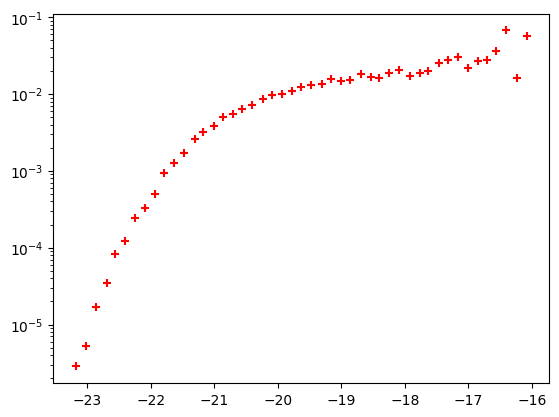

In [2]:
datos = pd.read_csv('data.csv')
magnitud = datos.iloc[:, 0]
funcionlum = datos.iloc[:, 1]
plt.scatter(magnitud, funcionlum, marker='+', color='red')
plt.yscale('log')

In [3]:
def	schechter(x,M,phi,alpha):
				m = 0.4*np.log(10)*phi*(10**(-0.4*(x-M)*(alpha+1)))*np.exp(-10**(-0.4*(x-M)))
				return m

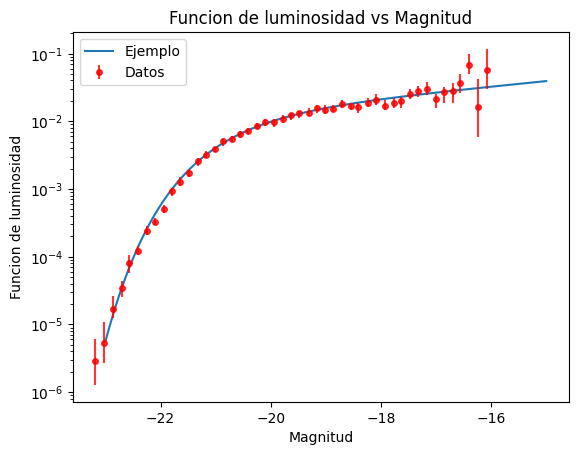

In [4]:
xgraf = np.linspace(-23, -15, 100)
ygraf = schechter(xgraf, -20.83, 1.46*(10**-2), -1.2)

erromin = datos.iloc[:,2]
erromax = datos.iloc[:,3]


plt.plot(xgraf, ygraf, label='Ejemplo')
plt.errorbar(magnitud,funcionlum,yerr=[erromin, erromax],color='red', alpha=0.8, fmt='o', label='Datos', markersize=4)
plt.yscale('log')
plt.xlabel('Magnitud')
plt.ylabel('Funcion de luminosidad')
plt.title('Funcion de luminosidad vs Magnitud')
plt.legend()
plt.show()

Ahora, probamos variando los parámetros, uno a la vez, para ver como afectan al resultado:

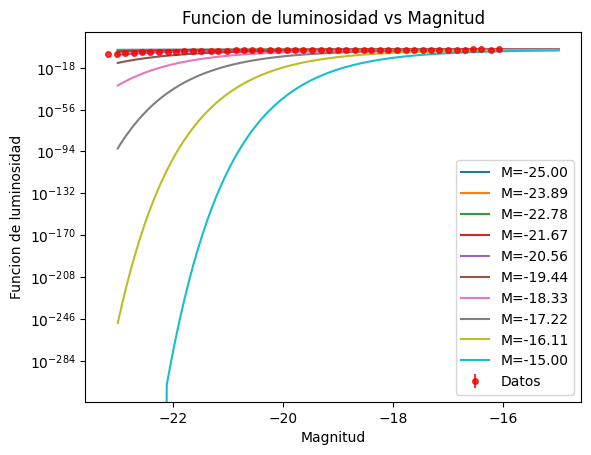

In [5]:
xgraf = np.linspace(-23, -15, 100)
#Variamos M
for M in np.linspace(-25, -15, 10):
	ygraf = schechter(xgraf, M, 1.46*(10**-2), -1.2)
	plt.plot(xgraf, ygraf, label=f'M={M:.2f}')

erromin = datos.iloc[:, 2]
erromax = datos.iloc[:, 3]

plt.errorbar(magnitud, funcionlum, yerr=[erromin, erromax], color='red', alpha=0.8, fmt='o', label='Datos', markersize=4)
plt.yscale('log')
plt.xlabel('Magnitud')
plt.ylabel('Funcion de luminosidad')
plt.title('Funcion de luminosidad vs Magnitud')
plt.legend()
plt.show()


Me zarpé, reduzcamos:

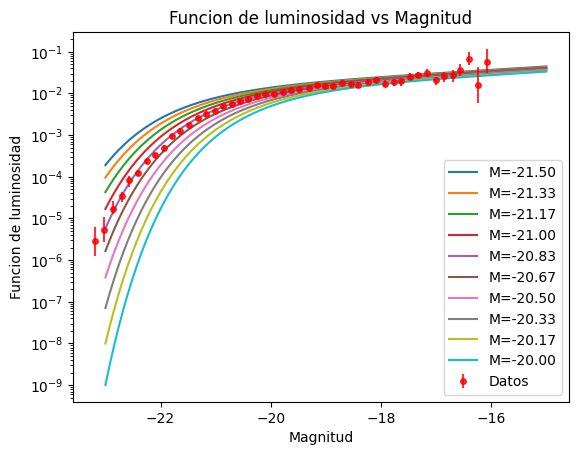

In [6]:
xgraf = np.linspace(-23, -15, 100)
#Variamos M
for M in np.linspace(-21.5, -20, 10):
	ygraf = schechter(xgraf, M, 1.46*(10**-2), -1.2)
	plt.plot(xgraf, ygraf, label=f'M={M:.2f}')

erromin = datos.iloc[:, 2]
erromax = datos.iloc[:, 3]

plt.errorbar(magnitud, funcionlum, yerr=[erromin, erromax], color='red', alpha=0.8, fmt='o', label='Datos', markersize=4)
plt.yscale('log')
plt.xlabel('Magnitud')
plt.ylabel('Funcion de luminosidad')
plt.title('Funcion de luminosidad vs Magnitud')
plt.legend()
plt.show()

Es razonable, entonces, entre -21 y -20.6 irá M

Ahora, veamos $\phi$

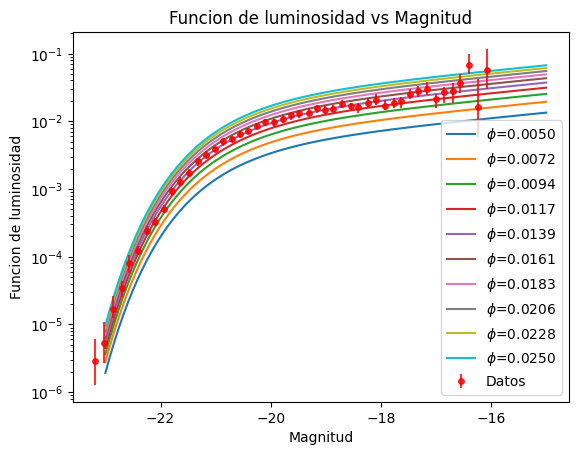

In [7]:
xgraf = np.linspace(-23, -15, 100)
#Variamos phi
for phi in np.linspace(0.5*(10**-2), 2.5*(10**-2), 10):
	ygraf = schechter(xgraf, -20.83, phi, -1.2)
	plt.plot(xgraf, ygraf, label=f'$\phi$={phi:.4f}')

erromin = datos.iloc[:, 2]
erromax = datos.iloc[:, 3]

plt.errorbar(magnitud, funcionlum, yerr=[erromin, erromax], color='red', alpha=0.8, fmt='o', label='Datos', markersize=4)
plt.yscale('log')
plt.xlabel('Magnitud')
plt.ylabel('Funcion de luminosidad')
plt.title('Funcion de luminosidad vs Magnitud')
plt.legend()
plt.show()

Razonable, por lo tanto $\phi \in [1.2,1.6]10^{-2}$

Finalmente, veamos $\alpha$

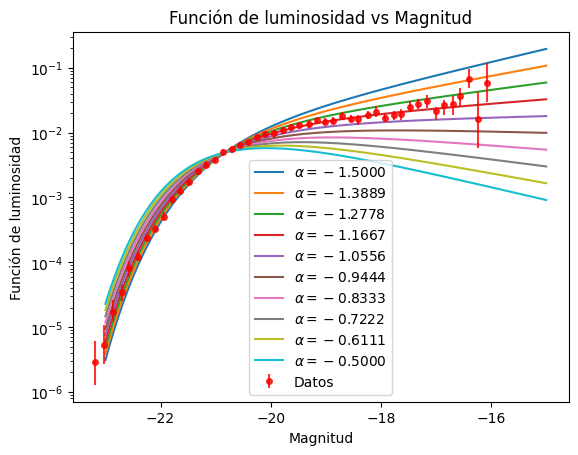

In [8]:
xgraf = np.linspace(-23, -15, 100)
# Variamos alpha
for alpha in np.linspace(-1.5, -0.5, 10):
	ygraf = schechter(xgraf, -20.83, 1.46*(10**-2), alpha)
	plt.plot(xgraf, ygraf, label=f'$\\alpha={alpha:.4f}$')

erromin = datos.iloc[:, 2]
erromax = datos.iloc[:, 3]

plt.errorbar(magnitud, funcionlum, yerr=[erromin, erromax], color='red', alpha=0.8, fmt='o', label='Datos', markersize=4)
plt.yscale('log')
plt.xlabel('Magnitud')
plt.ylabel('Función de luminosidad')
plt.title('Función de luminosidad vs Magnitud')
plt.legend()
plt.show()

Definamos entonces lo necesario para el algoritmo:

In [9]:
def loglike(x, y, M, phi, alpha, sigma):
				m = schechter(x, M, phi, alpha)
				L = -(1/2) * np.sum(((y - m) / sigma) ** 2)
				return L

In [10]:
alphamin = -1.5
alphamax = -1.3
Mmin = -21
Mmax = -20.6
phimin = 1.2*(10**(-2))
phimax = 1.6*(10 ** (-2))

In [11]:
bordeinferr =	np.array([Mmin, phimin, alphamin])
bordesuperr = np.array([Mmax, phimax, alphamax])

def priors(params):
	if np.all(bordeinferr <= params) and np.all(params <= bordesuperr):
		return 0
	else:
		return -np.inf

In [12]:
def post(x, y, M, phi, alpha, sigma):
	params = np.array([M, phi, alpha])
	prior_prob = priors(params)
	if prior_prob == -np.inf:
		return prior_prob
	else:
		return loglike(x, y, M, phi, alpha, sigma) + prior_prob

Normalizemos

In [13]:
def normM(M):
    return (M - Mmin) / ( Mmax - Mmin)

def anti_normM(M):
				return (M * (Mmax - Mmin)) + Mmin

def normphi(phi):
				return (phi - phimin) / (phimax - phimin)

def anti_normphi(phi):
				return (phi * (phimax - phimin)) + phimin

def normalpha(alpha):
				return (alpha - alphamin) / (alphamax - alphamin)

def anti_normalpha(alpha):
				return (alpha * (alphamax - alphamin)) + alphamin

Ahora, armemos el algoritmo:

In [14]:
def mc(x, y, sigma, N):
	#Lanzamos en un lugar al azar dentro de los priors.
	M = np.random.uniform(Mmin, Mmax)
	phi = np.random.uniform(phimin, phimax)
	alpha = np.random.uniform(alphamin, alphamax)
	#Armamos las listas donde guardaremos todo
	Mreccorridos	= np.zeros(N+1)
	phirecorridos = np.zeros(N+1)
	alpharecorridos = np.zeros(N+1)
	p = np.zeros(N+1)
	#Calculamos el primer valor de la probabilidad
	p[0] = post(x, y, M, phi, alpha, sigma)
	#Guardamos los primeros valores
	Mreccorridos[0] = M
	phirecorridos[0] = phi
	alpharecorridos[0] = alpha
	#Empezamos a recorrer
	for i in range(N):
		#Damos pasos inversamente proporcionales a la probabilidad, de modo que sean largos lejos del pico, y cortos cerca del pico.
		if i <	N/10:
			pp	= 1e-2
		elif i < (2*N)/10:
			pp = 1e-3
		else:
				pp = 1e-4
		M_paso = normM(M) + np.random.uniform(-1,1)*pp
		phi_paso = normphi(phi) + np.random.uniform(-1,1)*pp
		alpha_paso = normalpha(alpha) + np.random.uniform(-1,1)*pp
		
		#Ahora, desonormalizamos para calcular la probabilidad:
		M_paso = anti_normM(M_paso)
		phi_paso = anti_normphi(phi_paso)
		alpha_paso = anti_normalpha(alpha_paso)

		#Ahora, si la probabilidad del paso es mayor a la probabilidad actual, nos movemos a ese paso.
		if post(x, y, M_paso, phi_paso, alpha_paso, sigma)-post(x, y, M, phi, alpha, sigma)>np.log(np.random.uniform(0,1)):
			#Me los guardo en la lista
			Mreccorridos[i+1] = M_paso
			phirecorridos[i+1] = phi_paso
			alpharecorridos[i+1] = alpha_paso
			#Avanzo
			M = M_paso
			phi = phi_paso
			alpha = alpha_paso
			p[i+1] = post(x, y, M_paso, phi_paso, alpha_paso, sigma)
		else: #Sino, nos quedamos en el molde. Guardamos el mismo valor.
			Mreccorridos[i+1] = M
			phirecorridos[i+1] = phi
			alpharecorridos[i+1] = alpha
			#Mantengo la misma probabilidad pues no me movi.
			p[i+1] = post(x, y, M, phi, alpha, sigma)
	#Obtengo todos los valores de los parametros
	return	Mreccorridos, phirecorridos, alpharecorridos, p

In [17]:
sigma = (erromax-erromin)/2
mcad, phicad, alphacad, logpcad = mc(magnitud, funcionlum, sigma, 50000)

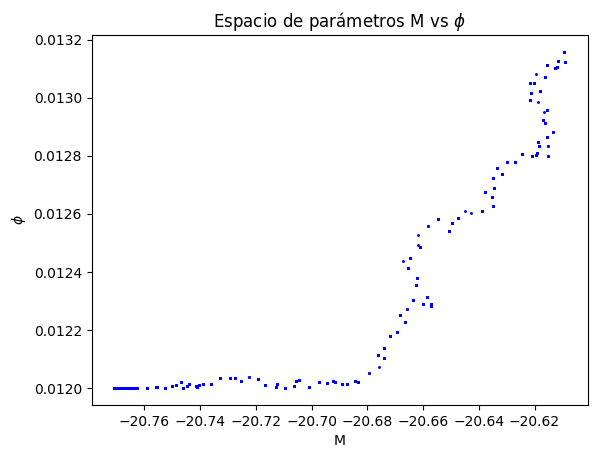

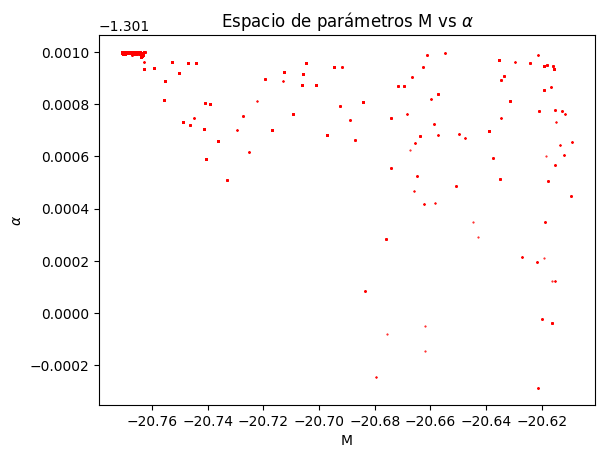

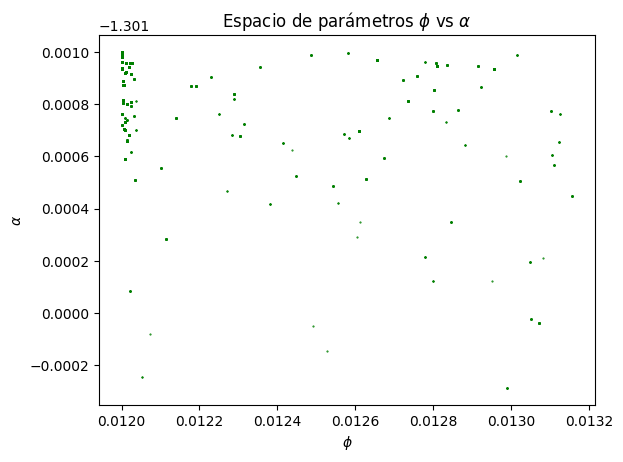

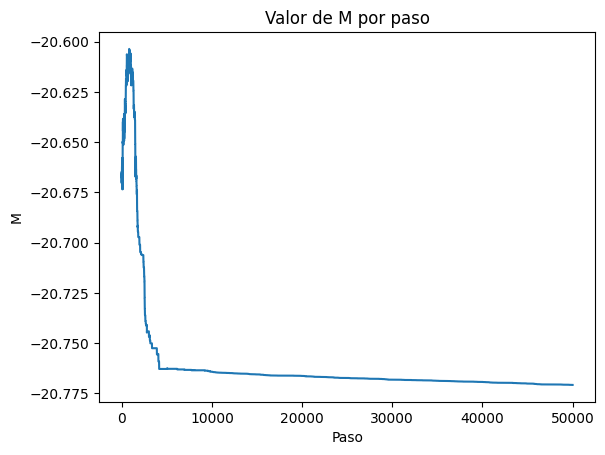

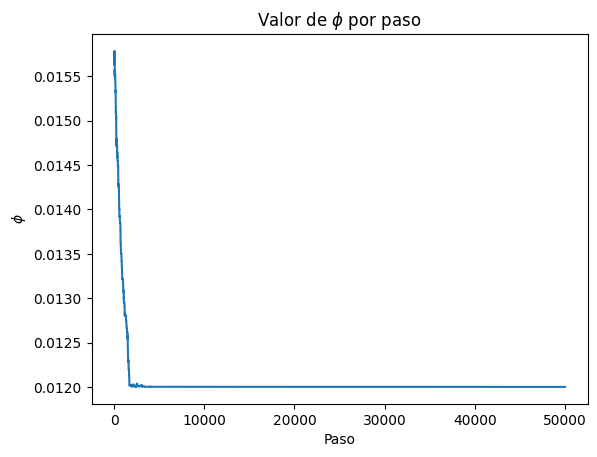

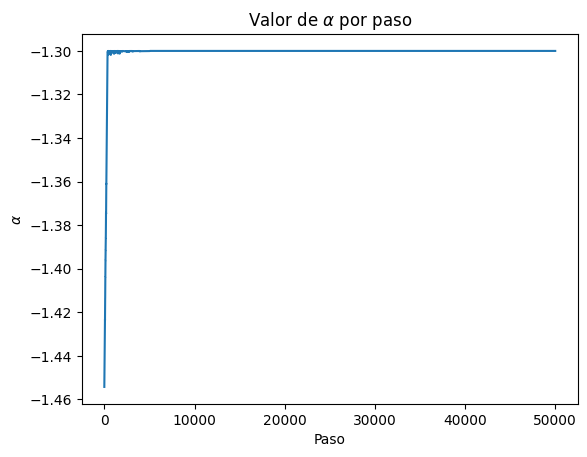

[-20.67012257 -20.66981801 -20.66981801 ... -20.77085261 -20.77085261
 -20.77085261]
[0.01574856 0.01573585 0.01573585 ... 0.01200003 0.01200003 0.01200003]
[-1.45425881 -1.45374609 -1.45374609 ... -1.30000011 -1.30000011
 -1.30000011]
[-1654339.35513989 -1641469.97232636 -1641469.97232636 ...
   -89816.35629181   -89816.35629181   -89816.35629181]
[0. 0. 0. ... 0. 0. 0.]


In [19]:
# Gráfico de M vs phi
plt.scatter(mcad[1000:], phicad[1000:], c='blue',marker='.',s=5)
plt.xlabel('M')
plt.ylabel('$\phi$')
plt.title('Espacio de parámetros M vs $\phi$')
plt.show()
# Gráfico de M vs alpha
plt.scatter(mcad[1000:], alphacad[1000:], c='red', marker='.', s=1)
plt.xlabel('M')
plt.ylabel('$\\alpha$')
plt.title('Espacio de parámetros M vs $\\alpha$')
plt.show()
# Gráfico de phi vs alpha
plt.scatter(phicad[1000:], alphacad[1000:], c='green',	marker='.', s=1)
plt.xlabel('$\phi$')
plt.ylabel('$\\alpha$')
plt.title('Espacio de parámetros $\phi$ vs $\\alpha$')
plt.show()

#Valor por cada paso
plt.plot(mcad)
plt.xlabel('Paso')
plt.ylabel('M')
plt.title('Valor de M por paso')
plt.show()

plt.plot(phicad)
plt.xlabel('Paso')
plt.ylabel('$\phi$')
plt.title('Valor de $\phi$ por paso')
plt.show()

plt.plot(alphacad)
plt.xlabel('Paso')
plt.ylabel('$\\alpha$')
plt.title('Valor de $\\alpha$ por paso')
plt.show()

#Ver que las cosas den con sentido
print(mcad)
print(phicad)
print(alphacad)
print(logpcad)
print(np.exp(logpcad))